# Transfer Learning on Video Data
by Gaetano Bonofiglio, Veronica Iovinella

## Introduction
We previously used Transfer Learning from Inception Model to build a classifier on CIFAR-10, which is actually a common dataset for image recognition (despite the very low resolution), with many of different examples for the 10 classes. The dataset allows to reach 80% accuracy with a simple CNN and 90% using Transfer Learning with proper feature extraction using Inception Model. 

In this notebook we will study how the technique performs on a custom dataset built around strenghts and weaknesses of the Inception Model, that is built around ImageNet. The dataset is called **apple-drive-duck** and we obtained it by sampling videos we made, containing pictures of apples, hard drives and rubber ducks. Those objects were chosen according to ImageNet strengths and weaknesses. ImageNet has a lot of pictures of apples (24 categories with thousands of images each), very few hard drive images (68 total) and zero rubber ducks (maybe there are collateral rubber ducks in some bathroom or toy images, but ImageNet has no rubber duck class, so the actual number is zero or close to zero, rubber ducks are classified as "baloon" by Inception Model V3). This should give a good variety to study how Transfer Learning behaves with new classes and old classes, also with few examples.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import os

from util import Util
u = Util()

import inception

import prettytensor as pt

tf.__version__

'0.9.0'

In [2]:
import custom_dataset as add
from custom_dataset import num_classes

## Load data

In [3]:
add.dataset_name = "apple-drive-duck"
add.data_dir = "data/" + add.dataset_name + "/"
add.data_url = "https://github.com/Kidel/Deep-Learning-CNN-for-Image-Recognition/raw/master/customData/apple-drive-duck.tar.gz"
# Directory used for the cache files
cache_dir = "cache/"
data_dir = cache_dir + add.dataset_name +"/"

The dataset will be downloaded automatically if not downloaded already. It's about 19 MB.

In [4]:
add.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Now we have to load the dataset. The loader scans the directories and sub-directories for all jpg files and puts them into two lists for the training-set and test-set. This does not actually cache the images, which will be done when the transfer-values are being calculated further below.

The lists of filenames are saved so we can be sure that they are ordered in the same way when reloading the dataset later. This is important so we keep the link between the images and their corresponding Transfer-Values.

In [5]:
dataset = add.load()

Creating dataset from the files in: data/apple-drive-duck/
- Data loaded from cache-file: data/apple-drive-duck/apple-drive-duck.pkl


From *dataset* we can obtain class names and also the paths for the images of the training set and the test set.

In [6]:
class_names = dataset.class_names
class_names

['duck', 'drive', 'apple']

In [7]:
image_paths_train, cls_train, labels_train = dataset.get_training_set()
# This line prints the first image-path to see if it's ok
image_paths_train[0]

'/home/jovyan/work/Deep-Learning-CNN-for-Image-Recognition/data/apple-drive-duck/duck/duck3-0041.jpg'

In [8]:
image_paths_test, cls_test, labels_test = dataset.get_test_set()
# This line prints the first image-path to see if it's ok
image_paths_test[0]

'/home/jovyan/work/Deep-Learning-CNN-for-Image-Recognition/data/apple-drive-duck/duck/test/duck_test-0138.jpg'

Some statistics on the dataset

In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(image_paths_train)))
print("- Test-set:\t\t{}".format(len(image_paths_test)))

Size of:
- Training-set:		1430
- Test-set:		442


### Helper-function for plotting images

In [10]:
def plot_images(images, cls_true, cls_pred=None, smooth=True): 
    u.plot_images_2(images=images, cls_true=cls_true, class_names=class_names, cls_pred=cls_pred, smooth=smooth)

Some plots to see if everything is ok

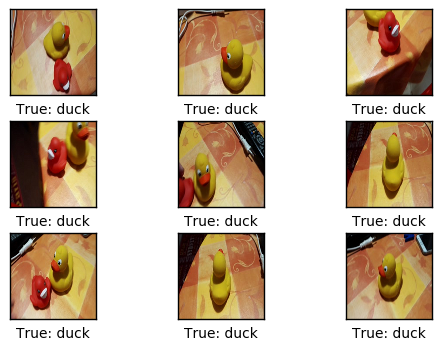

In [11]:
from matplotlib.image import imread

def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images)

# Load the first images from the test-set.
images = load_images(image_paths=image_paths_test[0:9])

# Get the true classes for those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

### Download and Load the Inception Model

In [12]:
# inception.data_dir = 'inception/'
inception.maybe_download()

model = inception.Inception()

Data has apparently already been downloaded and unpacked.


Here we set the paths where Inception model will save the Transfer-Values in cache files.

In [13]:
from inception import transfer_values_cache

file_path_cache_train = os.path.join(cache_dir, 'inception-add-train.pkl')
file_path_cache_test = os.path.join(cache_dir, 'inception-add-test.pkl')

This time we don't need to scale how pixel values are coded, since we already have jpegs. We can calculate the Transfer-Values right away.

In [14]:
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              image_paths=image_paths_train,
                                              model=model)

transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             image_paths=image_paths_test,
                                             model=model)

- Processing image:   1430 / 1430


PermissionError: [Errno 13] Permission denied: 'cache/inception-add-train.pkl'

We can check the shapes of the Transfer-Value arrays.

In [ ]:
transfer_values_train.shape

In [ ]:
transfer_values_test.shape

### Helper-function for plotting Transfer-Values

In [ ]:
def plot_transfer_values(i): 
    u.plot_transfer_values(i=i, images=images, transfer_values=transfer_values_test)

In [ ]:
plot_transfer_values(1)

## Analysis of Transfer-Values
As we did in the last notebook, we want to check if the Transfer-Values retain enough information to discriminate between the different classes.
To do so, we are going to use the same two clustering algorithms we used before: PCA and t-SNE.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transfer_values = transfer_values_train
cls = cls_train

# First we reduce the dimensions from 2048 to 50 using PCA
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

# Then we reduce to 2 dimensions using t-SNE
tsne = TSNE(n_components=2)
transfer_values_reduced = tsne.fit_transform(transfer_values_50d)

# Helper function to plot the scatter
def plot_scatter(values, cls): 
    u.plot_scatter(values=values, cls=cls, num_classes=num_classes)

In [ ]:
plot_scatter(transfer_values_reduced, cls)